In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df = pd.read_json(r'C:\Users\Linds\Repos\East_River\Data\Raw\DSU_wx_history_redo.json')
print(df.head())

                 SELECT *\r\nFROM er_test.wx_history
0  {'location': 'Aberdeen, South Dakota', 'obs_tm...
1  {'location': 'Alsville, South Dakota', 'obs_tm...
2  {'location': 'Ames, South Dakota', 'obs_tms_lc...
3  {'location': 'Andover, South Dakota', 'obs_tms...
4  {'location': 'Arco, Minnesota', 'obs_tms_lcl':...


In [3]:
# Display dataframe information
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6084216 entries, 0 to 6084215
Data columns (total 1 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   SELECT *
FROM er_test.wx_history  object
dtypes: object(1)
memory usage: 46.4+ MB


In [4]:

# create a new DataFrame with separate columns by normalizing the JSON data.
df_parsed = pd.json_normalize(df.iloc[:, 0])
print(df_parsed.head())

                 location               obs_tms_lcl  temperature  wind_speed  \
0  Aberdeen, South Dakota  2020-12-31T06:00:00.000Z           12           7   
1  Alsville, South Dakota  2020-12-31T06:00:00.000Z            5           5   
2      Ames, South Dakota  2020-12-31T06:00:00.000Z           16           7   
3   Andover, South Dakota  2020-12-31T06:00:00.000Z           12           7   
4         Arco, Minnesota  2020-12-31T06:00:00.000Z            7           6   

   wind_degree wind_dir weather_descriptions  precip  humidity  visibility  \
0          197      SSW               Cloudy     0.0        90           6   
1          206      SSW               Cloudy     0.0        86           6   
2          165      SSE                Clear     0.0        84           6   
3          197      SSW               Cloudy     0.0        90           6   
4          228       SW               Cloudy     0.0        88           6   

   pressure  cloudcover  heatindex  dewpoint  wind

In [5]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6084216 entries, 0 to 6084215
Data columns (total 18 columns):
 #   Column                Dtype  
---  ------                -----  
 0   location              object 
 1   obs_tms_lcl           object 
 2   temperature           int64  
 3   wind_speed            int64  
 4   wind_degree           int64  
 5   wind_dir              object 
 6   weather_descriptions  object 
 7   precip                float64
 8   humidity              int64  
 9   visibility            int64  
 10  pressure              float64
 11  cloudcover            int64  
 12  heatindex             int64  
 13  dewpoint              int64  
 14  windchill             int64  
 15  windgust              int64  
 16  feelslike             int64  
 17  uv_index              int64  
dtypes: float64(2), int64(12), object(4)
memory usage: 835.5+ MB


In [6]:
df_parsed['temperature'] = df_parsed['temperature'].astype(float)

In [7]:
# Identify numeric columns and convert them to float
num_cols = df_parsed.select_dtypes(include=['number']).columns
df_parsed[num_cols] = df_parsed[num_cols].astype(float)

Upsample to a half-hour frequency and use time-based linear interpolation for the missing weather data, keeping all locations


In [8]:
# Convert the timestamp column and set the multi-index
df_parsed['datetime'] = pd.to_datetime(df_parsed['obs_tms_lcl'])
df_parsed.set_index(['location', 'datetime'], inplace=True)
# Remove any duplicate indices, if necessary
df_parsed = df_parsed[~df_parsed.index.duplicated(keep='first')]

# Identify numeric and non-numeric columns
num_cols = df_parsed.select_dtypes(include=['number']).columns
non_num_cols = df_parsed.select_dtypes(exclude=['number']).columns

# For numeric columns: apply time-based linear interpolation
df_numeric = df_parsed[num_cols].groupby(level='location').apply(
    lambda grp: grp.reset_index(level='location', drop=True)
                  .resample("30T")
                  .interpolate(method='time')
)

# For non-numeric columns: apply forward-fill
df_non_numeric = df_parsed[non_num_cols].groupby(level='location').apply(
    lambda grp: grp.reset_index(level='location', drop=True)
                  .resample("30T")
                  .ffill()
)

# Combine the numeric and non-numeric DataFrames
df_parsed = pd.concat([df_numeric, df_non_numeric], axis=1)
df_parsed.reset_index(inplace=True)


In [9]:
print("Missing values count per column in df_parsed:")
print(df_parsed.isnull().sum())


Missing values count per column in df_parsed:
location                0
datetime                0
temperature             0
wind_speed              0
wind_degree             0
precip                  0
humidity                0
visibility              0
pressure                0
cloudcover              0
heatindex               0
dewpoint                0
windchill               0
windgust                0
feelslike               0
uv_index                0
obs_tms_lcl             0
wind_dir                0
weather_descriptions    0
dtype: int64


In [10]:
# Display the count of missing values per column in both dataframes

print("Missing values count per column in df:")
print(df.isnull().sum())

print("\nMissing values count per column in df_parsed:")
print(df_parsed.isnull().sum())

Missing values count per column in df:
SELECT *\r\nFROM er_test.wx_history    0
dtype: int64

Missing values count per column in df_parsed:
location                0
datetime                0
temperature             0
wind_speed              0
wind_degree             0
precip                  0
humidity                0
visibility              0
pressure                0
cloudcover              0
heatindex               0
dewpoint                0
windchill               0
windgust                0
feelslike               0
uv_index                0
obs_tms_lcl             0
wind_dir                0
weather_descriptions    0
dtype: int64


Verifty timestamp frequency

In [11]:
# Verify the timestamp frequency by checking the difference between consecutive timestamps per location

expected_interval = pd.Timedelta("30T")
# Compute the difference between consecutive datetime entries for each location
ts_diff = df_parsed.groupby('location')['datetime'].diff()

# Identify any differences that don't match the expected interval, ignoring the first NaT of each group
incorrect_diffs = ts_diff[~ts_diff.isna() & (ts_diff != expected_interval)]

if incorrect_diffs.empty:
    print("All timestamps have the expected frequency of 30 minutes.")
else:
    print("Timestamps with unexpected frequency found:")
    print(incorrect_diffs)

All timestamps have the expected frequency of 30 minutes.


Check the timestamp differences for each location


In [12]:
# Count the number of timestamps for each location
timestamp_counts = df_parsed.groupby('location')['datetime'].count()

if timestamp_counts.nunique() == 1:
    print("All locations have the same number of timestamps.")
else:
    print("Not all locations have the same number of timestamps.")
    print(timestamp_counts)

All locations have the same number of timestamps.


In [13]:
print("DataFrame Info:")
df_parsed.info()

print("\nDataFrame Statistical Summary:")
print(df_parsed.describe(include='all'))

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12168690 entries, 0 to 12168689
Data columns (total 19 columns):
 #   Column                Dtype              
---  ------                -----              
 0   location              object             
 1   datetime              datetime64[ns, UTC]
 2   temperature           float64            
 3   wind_speed            float64            
 4   wind_degree           float64            
 5   precip                float64            
 6   humidity              float64            
 7   visibility            float64            
 8   pressure              float64            
 9   cloudcover            float64            
 10  heatindex             float64            
 11  dewpoint              float64            
 12  windchill             float64            
 13  windgust              float64            
 14  feelslike             float64            
 15  uv_index              float64            
 16  obs_tms_lcl       

Check for consistent date range for each location. 

In [14]:
# For each location, compute the earliest and latest timestamps
date_ranges = df_parsed.groupby('location')['datetime'].agg(['min', 'max'])

print("Date ranges for each location:")
print(date_ranges)

# Check if all locations have the same date range
if date_ranges['min'].nunique() == 1 and date_ranges['max'].nunique() == 1:
    print("\nAll locations have a consistent date range.")
else:
    print("\nLocations have varying date ranges.")

Date ranges for each location:
                                                min                       max
location                                                                     
Aberdeen, South Dakota    2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Alsville, South Dakota    2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Ames, South Dakota        2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Andover, South Dakota     2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Arco, Minnesota           2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
...                                             ...                       ...
Wessington, South Dakota  2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Wheaton, Minnesota        2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Willow Lake, South Dakota 2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Worthing, South Dakota    2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Yankton, South Dakota     2020-12

Visual inspection

In [15]:
# Filter the DataFrame for a specific location, for example "Aberdeen, South Dakota"
location_filter = "Aberdeen, South Dakota"
filtered_df = df_parsed[df_parsed["location"] == location_filter]

# Display the first few rows of the filtered DataFrame
print(filtered_df.head())

                 location                  datetime  temperature  wind_speed  \
0  Aberdeen, South Dakota 2020-12-31 06:00:00+00:00         12.0         7.0   
1  Aberdeen, South Dakota 2020-12-31 06:30:00+00:00         11.0         7.0   
2  Aberdeen, South Dakota 2020-12-31 07:00:00+00:00         10.0         7.0   
3  Aberdeen, South Dakota 2020-12-31 07:30:00+00:00         10.0         7.0   
4  Aberdeen, South Dakota 2020-12-31 08:00:00+00:00         10.0         7.0   

   wind_degree  precip  humidity  visibility  pressure  cloudcover  heatindex  \
0        197.0     0.0      90.0         6.0    30.120        69.0       12.0   
1        196.0     0.0      90.0         6.0    30.105        61.0       11.0   
2        195.0     0.0      90.0         6.0    30.090        53.0       10.0   
3        194.0     0.0      89.5         6.0    30.090        45.5       10.0   
4        193.0     0.0      89.0         6.0    30.090        38.0       10.0   

   dewpoint  windchill  windgust

In [16]:
# Let's inspect the count and percentage of 0.0 values in each numeric column
total_rows = len(df_parsed)
for col in num_cols:
    zero_count = (df_parsed[col] == 0.0).sum()
    perc = 100 * zero_count / total_rows
    print(f"{col:15s} -> {zero_count} zeros, {perc:.2f}% of total")
    
# Based on these numbers, we can assess if many 0.0 values indicate missing data or valid zero readings.

temperature     -> 40220 zeros, 0.33% of total
wind_speed      -> 1203 zeros, 0.01% of total
wind_degree     -> 4465 zeros, 0.04% of total
precip          -> 11896377 zeros, 97.76% of total
humidity        -> 0 zeros, 0.00% of total
visibility      -> 262927 zeros, 2.16% of total
pressure        -> 0 zeros, 0.00% of total
cloudcover      -> 835753 zeros, 6.87% of total
heatindex       -> 40227 zeros, 0.33% of total
dewpoint        -> 75242 zeros, 0.62% of total
windchill       -> 64114 zeros, 0.53% of total
windgust        -> 264 zeros, 0.00% of total
feelslike       -> 64114 zeros, 0.53% of total
uv_index        -> 0 zeros, 0.00% of total


Missing percipitation data in this dataset. Need supplimental data.

In [17]:
# Check for duplicate rows in df_parsed
duplicates = df_parsed.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicate rows in df_parsed:", num_duplicates)

if num_duplicates > 0:
    print("Duplicate rows:")
    print(df_parsed[duplicates])
else:
    print("No duplicate rows found.")

Number of duplicate rows in df_parsed: 0
No duplicate rows found.


In [18]:
df_parsed.describe()

,temperature,wind_speed,wind_degree,precip,humidity,visibility,pressure,cloudcover,heatindex,dewpoint,windchill,windgust,feelslike,uv_index
count,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07
mean,4.814735e+01,1.010118e+01,1.948545e+02,2.390800e-03,6.806421e+01,5.488631e+00,2.998164e+01,4.282932e+01,4.856749e+01,3.606081e+01,4.355694e+01,1.631754e+01,4.385698e+01,2.323854e+00
std,2.374325e+01,4.881041e+00,9.753382e+01,1.973370e-02,2.195978e+01,1.424737e+00,2.581221e-01,3.716549e+01,2.425436e+01,1.977231e+01,2.818853e+01,6.978737e+00,2.857556e+01,2.010952e+00
min,-3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,2.888000e+01,0.000000e+00,-3.100000e+01,-3.500000e+01,-5.100000e+01,0.000000e+00,-5.100000e+01,1.000000e+00
25%,3.000000e+01,6.500000e+00,1.270000e+02,0.000000e+00,5.100000e+01,6.000000e+00,2.981500e+01,7.000000e+00,3.000000e+01,2.300000e+01,2.300000e+01,1.100000e+01,2.300000e+01,1.000000e+00
50%,4.900000e+01,9.000000e+00,1.805000e+02,0.000000e+00,7.100000e+01,6.000000e+00,2.997000e+01,3.200000e+01,4.900000e+01,3.600000e+01,4.550000e+01,1.550000e+01,4.550000e+01,1.000000e+00
75%,6.700000e+01,1.300000e+01,2.910000e+02,0.000000e+00,8.800000e+01,6.000000e+00,3.012000e+01,8.000000e+01,6.800000e+01,5.400000e+01,6.700000e+01,2.100000e+01,6.700000e+01,3.000000e+00
max,1.130000e+02,3.700000e+01,3.600000e+02,1.800000e+00,1.000000e+02,6.000000e+00,3.098000e+01,1.000000e+02,1.180000e+02,8.100000e+01,1.130000e+02,5.900000e+01,1.180000e+02,1.000000e+01


<Figure size 1200x800 with 0 Axes>

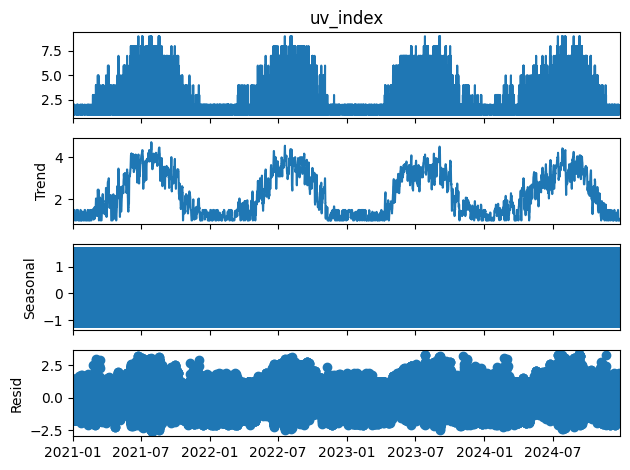

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Select the uv_index series for the sample location and set datetime as index
uv_series = filtered_df.set_index('datetime')[col].sort_index()

# Decompose the time series assuming daily seasonality (48 half-hour intervals per day)
decomposition = seasonal_decompose(uv_series, model='additive', period=48)

# Plot the observed, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.tight_layout()
plt.show()

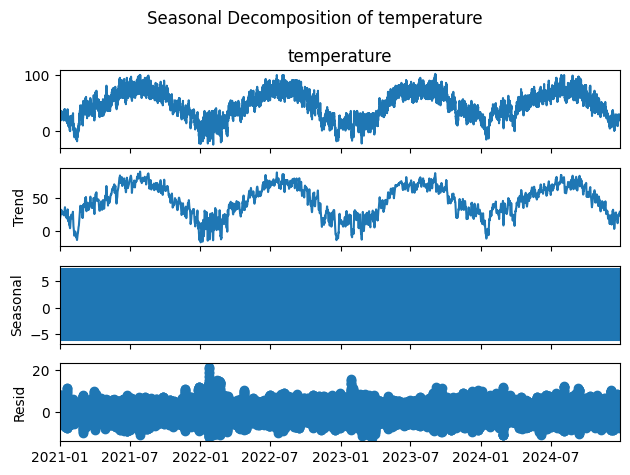

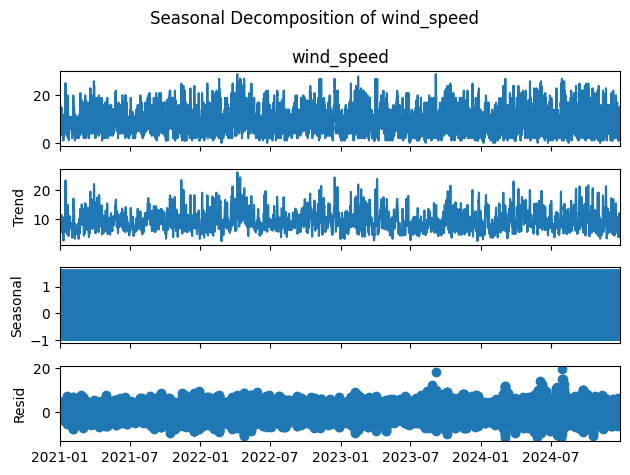

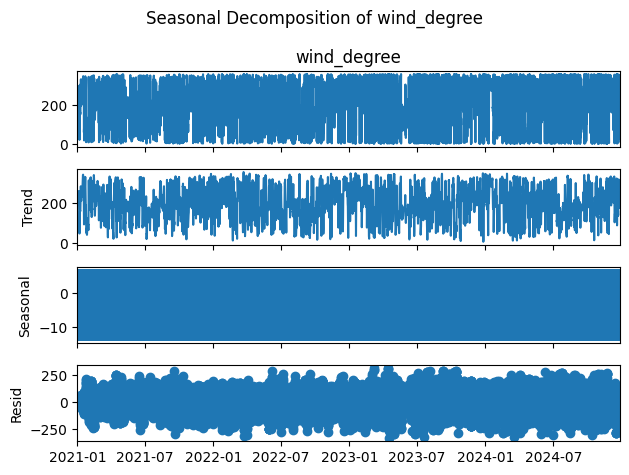

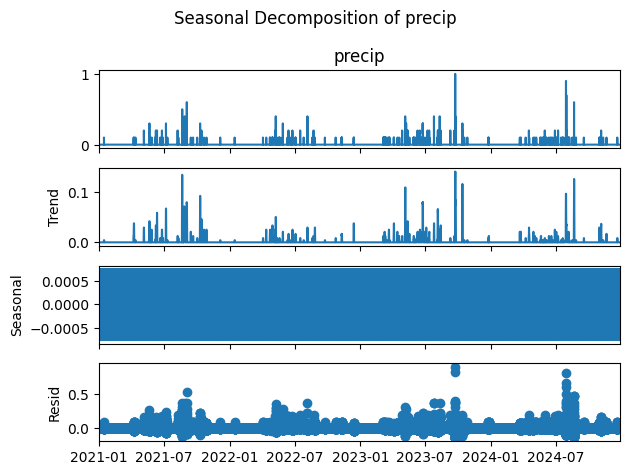

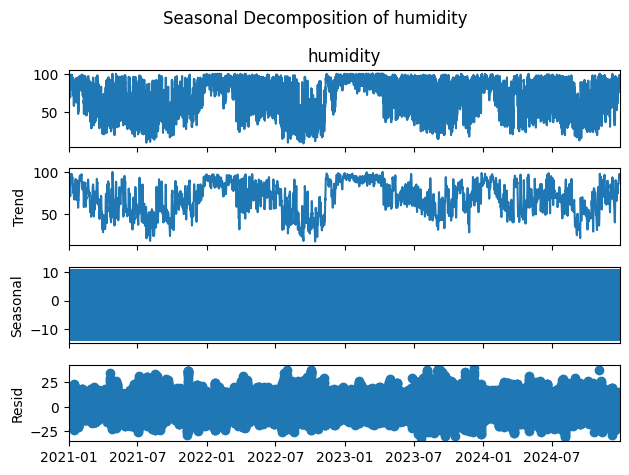

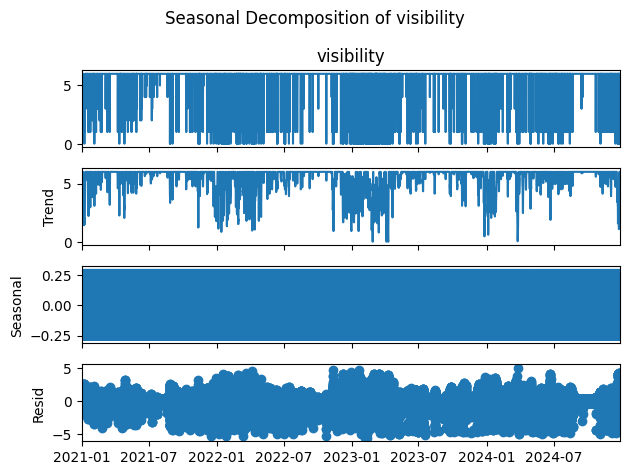

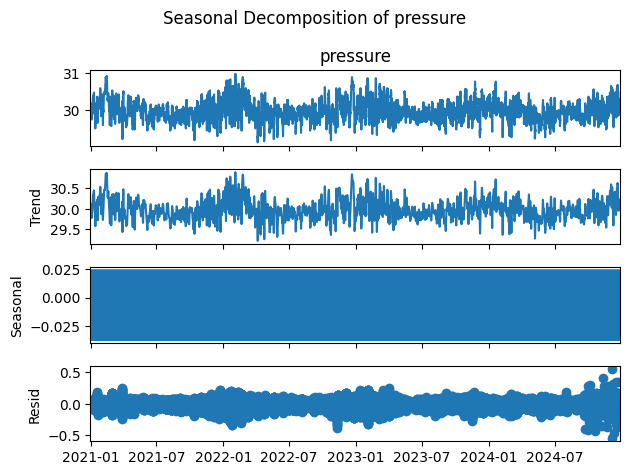

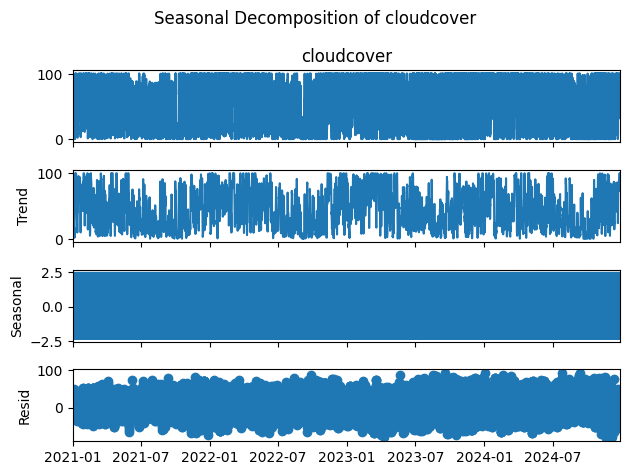

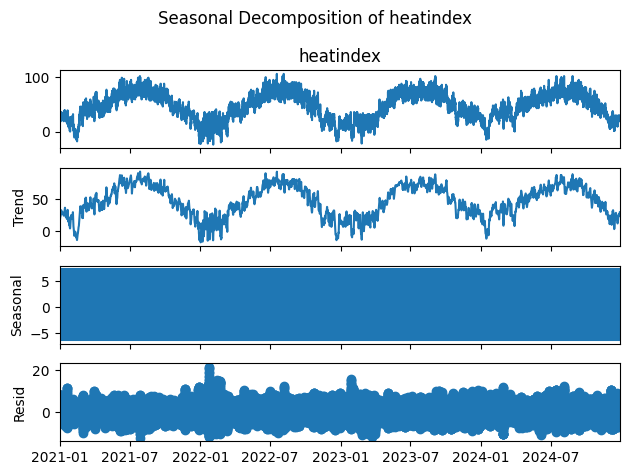

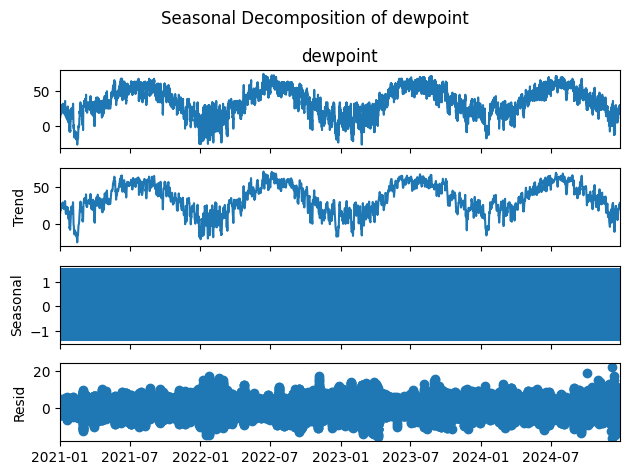

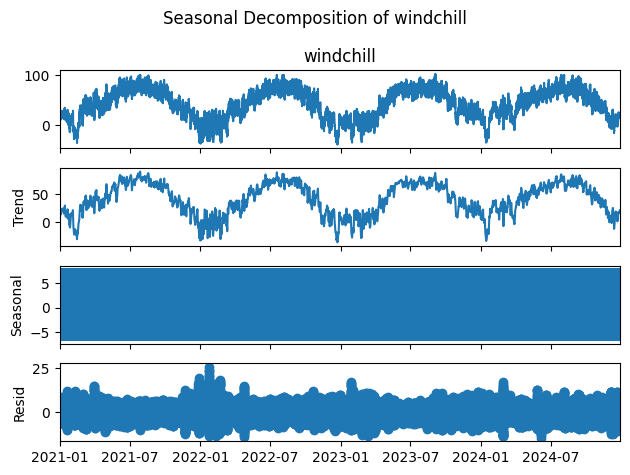

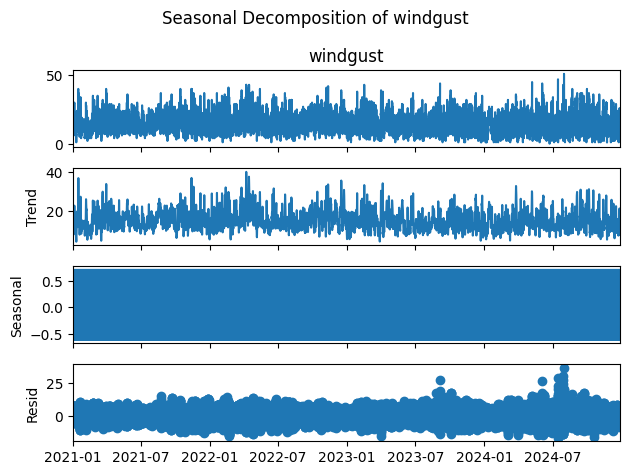

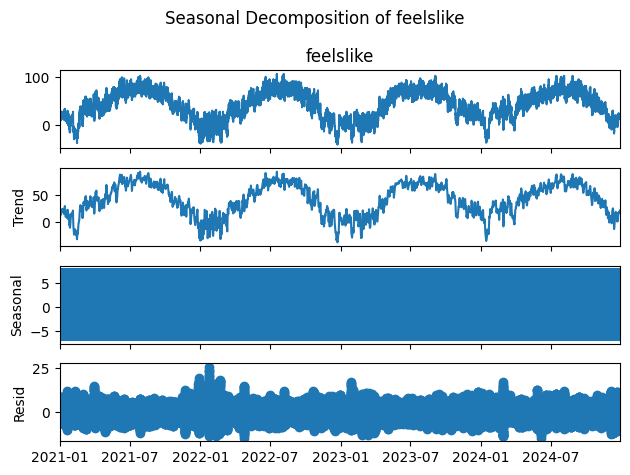

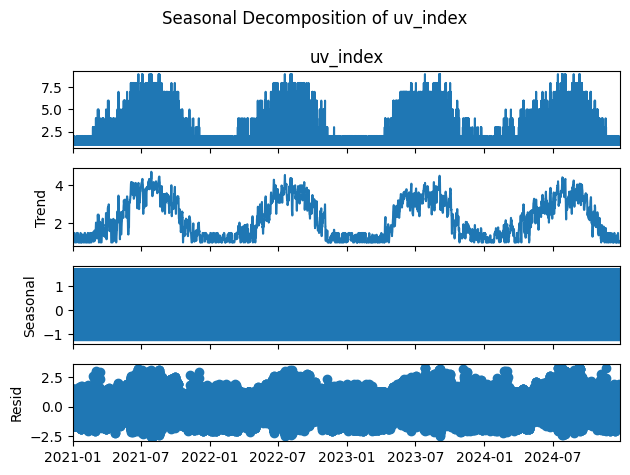

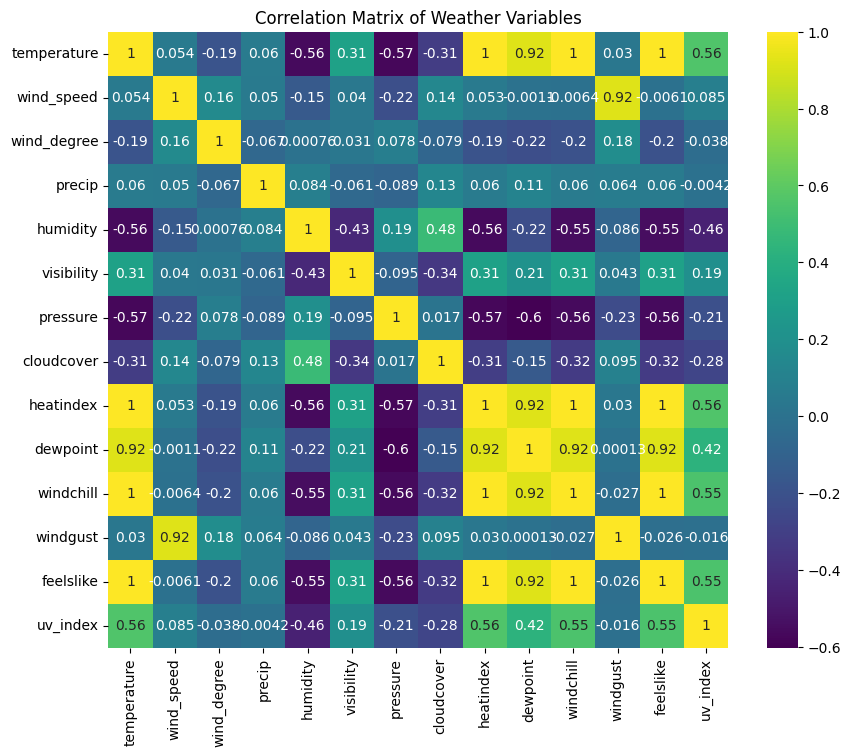

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings("ignore")

# Option 1: Seasonal decomposition for each numeric variable in filtered_df (for location_filter)
for var in num_cols:
    series = filtered_df.set_index('datetime')[var].sort_index()
    try:
        result = seasonal_decompose(series, model='additive', period=48)
        fig = result.plot()
        fig.suptitle(f"Seasonal Decomposition of {var}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Skipping {var}: {e}")

# Option 2: Compare all numeric variables with a correlation matrix
corr_matrix = filtered_df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title("Correlation Matrix of Weather Variables")
plt.show()

• We successfully parsed and normalized the JSON data, converting all relevant numeric columns (e.g., temperature) to float.

• The timestamps were confirmed to follow the expected 30-minute interval frequency, with no duplicate records found.

• The upsampling procedure maintained consistent date ranges across locations.

• High Correlations Among Temperature, Feelslike, Heatindex, and Windchill: These four are essentially different measures of the same phenomenon (perceived temperature), so they’re highly correlated.

• Moderate Correlation Between Temperature & UV Index: Warmer conditions often accompany higher UV levels, leading to a moderate positive correlation.

• Lower Correlation for Wind Speed/Degree and Precip: Wind variables and precipitation do not line up as closely with temperature-related measures, so they show weaker correlations.

• Pressure & Humidity: These variables have moderate correlations with temperature; they fluctuate with weather systems, but not as tightly as temperature does with heatindex/feelslike.

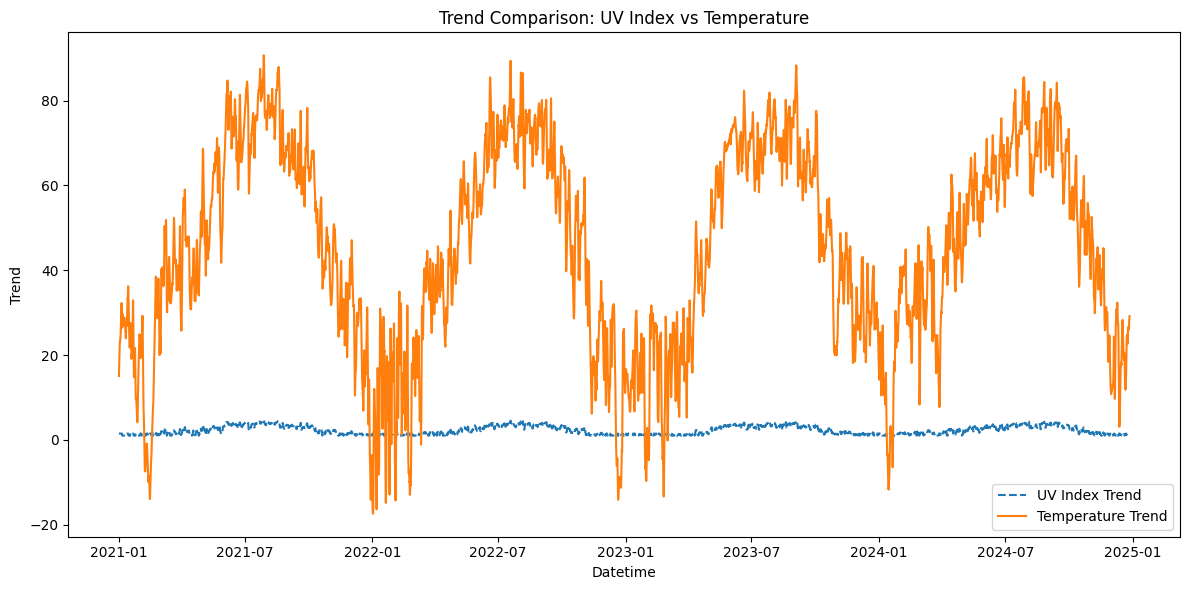

In [21]:
# Extract time series for uv_index and temperature from filtered_df
ts_uv = filtered_df.set_index('datetime')[col].sort_index()
ts_temp = filtered_df.set_index('datetime')['temperature'].sort_index()

# Perform seasonal decomposition with daily seasonality (48 half-hour intervals)
decomp_uv = seasonal_decompose(ts_uv, model='additive', period=48)
decomp_temp = seasonal_decompose(ts_temp, model='additive', period=48)

# Plot the trend components side by side for comparison
plt.figure(figsize=(12,6))
plt.plot(decomp_uv.trend, label="UV Index Trend", linestyle="--")
plt.plot(decomp_temp.trend, label="Temperature Trend", linestyle="-")
plt.legend()
plt.title("Trend Comparison: UV Index vs Temperature")
plt.xlabel("Datetime")
plt.ylabel("Trend")
plt.tight_layout()
plt.show()

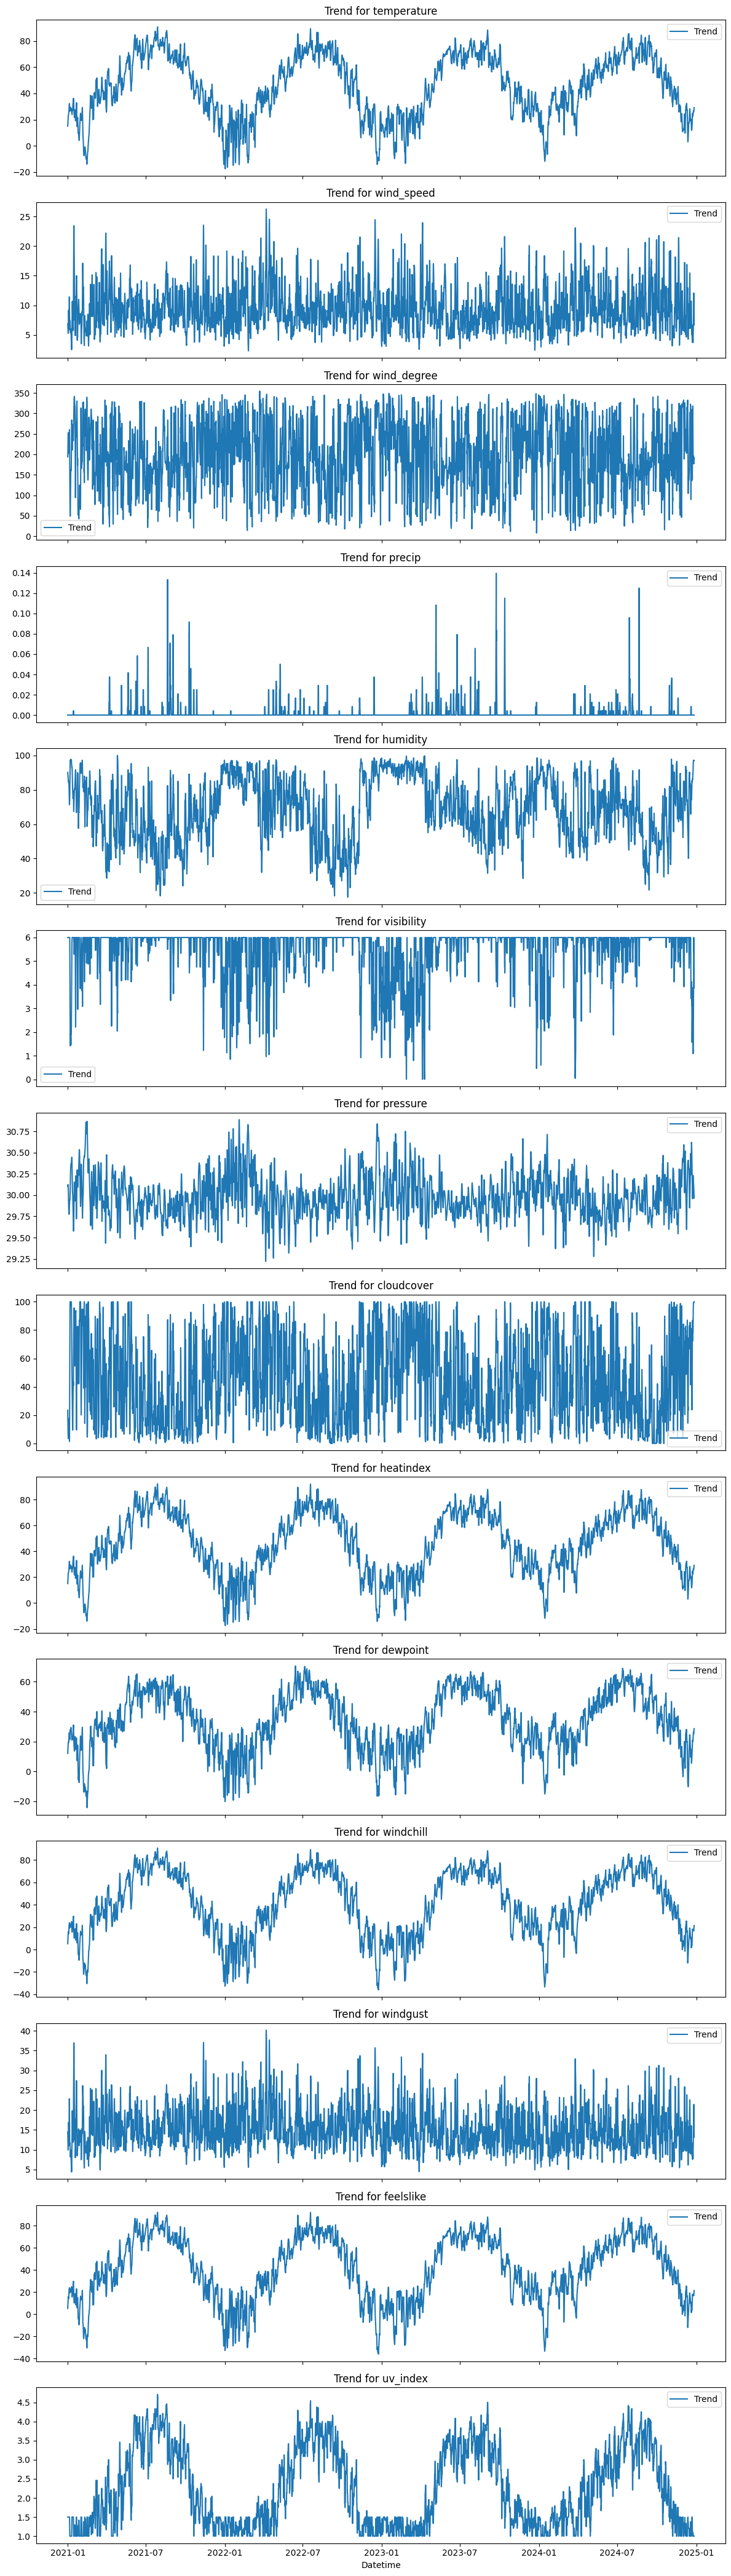

In [22]:
# Plot trend components for all numeric variables from filtered_df using seasonal_decompose
n_vars = len(num_cols)
fig, axes = plt.subplots(nrows=n_vars, figsize=(12, 3 * n_vars), sharex=True)

for i, var in enumerate(num_cols):
    series = filtered_df.set_index('datetime')[var].sort_index()
    try:
        decomp = seasonal_decompose(series, model='additive', period=48)
        axes[i].plot(decomp.trend, label='Trend', color='tab:blue')
        axes[i].set_title(f"Trend for {var}")
        axes[i].legend()
    except Exception as e:
        axes[i].text(0.5, 0.5, f"Error for {var}: {e}", ha='center', va='center')
        axes[i].set_title(f"Trend for {var}")

plt.xlabel("Datetime")
plt.tight_layout()
plt.show()

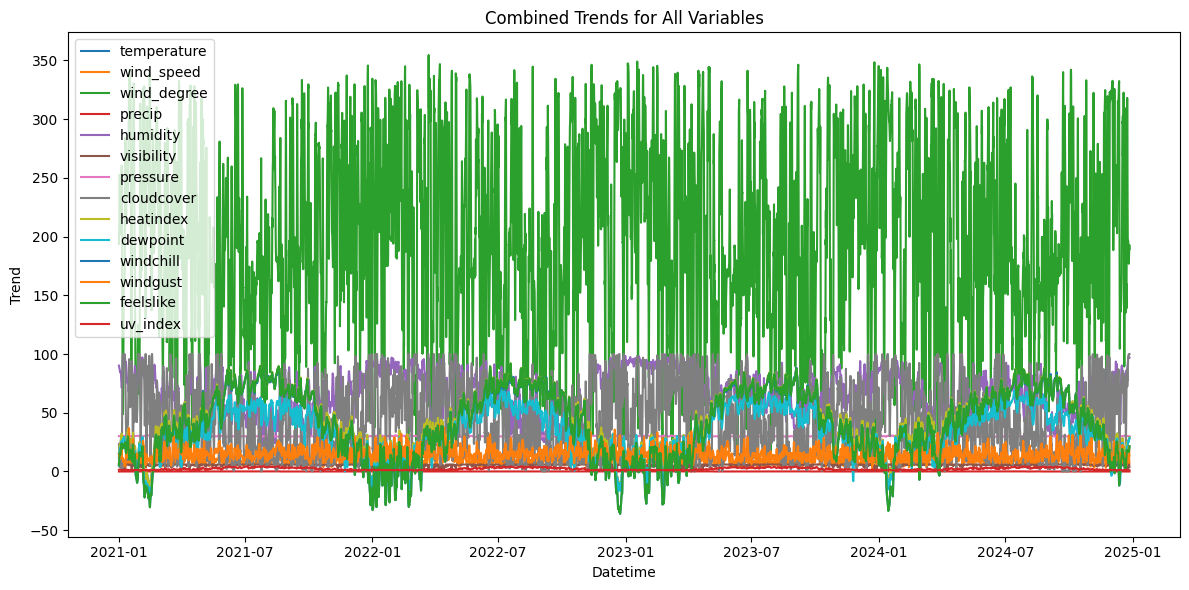

In [23]:
plt.figure(figsize=(12,6))
for var in num_cols:
    ts = filtered_df.set_index('datetime')[var].sort_index()
    try:
        decomp = seasonal_decompose(ts, model='additive', period=48)
        plt.plot(decomp.trend, label=var)
    except Exception as e:
        print(f"Skipping {var}: {e}")
plt.title("Combined Trends for All Variables")
plt.xlabel("Datetime")
plt.ylabel("Trend")
plt.legend()
plt.tight_layout()
plt.show()

The strong cyclical patterns indicate seasonal fluctuations in variables like temperature, humidity, and cloud cover. Notice how they rise and fall together over time, reflecting recurring seasonal or weather-related cycles.
Some variables (e.g., temperature, feelslike, heatindex) appear to have very similar shapes, suggesting they’re capturing the same underlying weather behavior.
Variables like wind speed or wind degree may show more irregular patterns or smaller amplitude changes compared to the temperature-related measures.

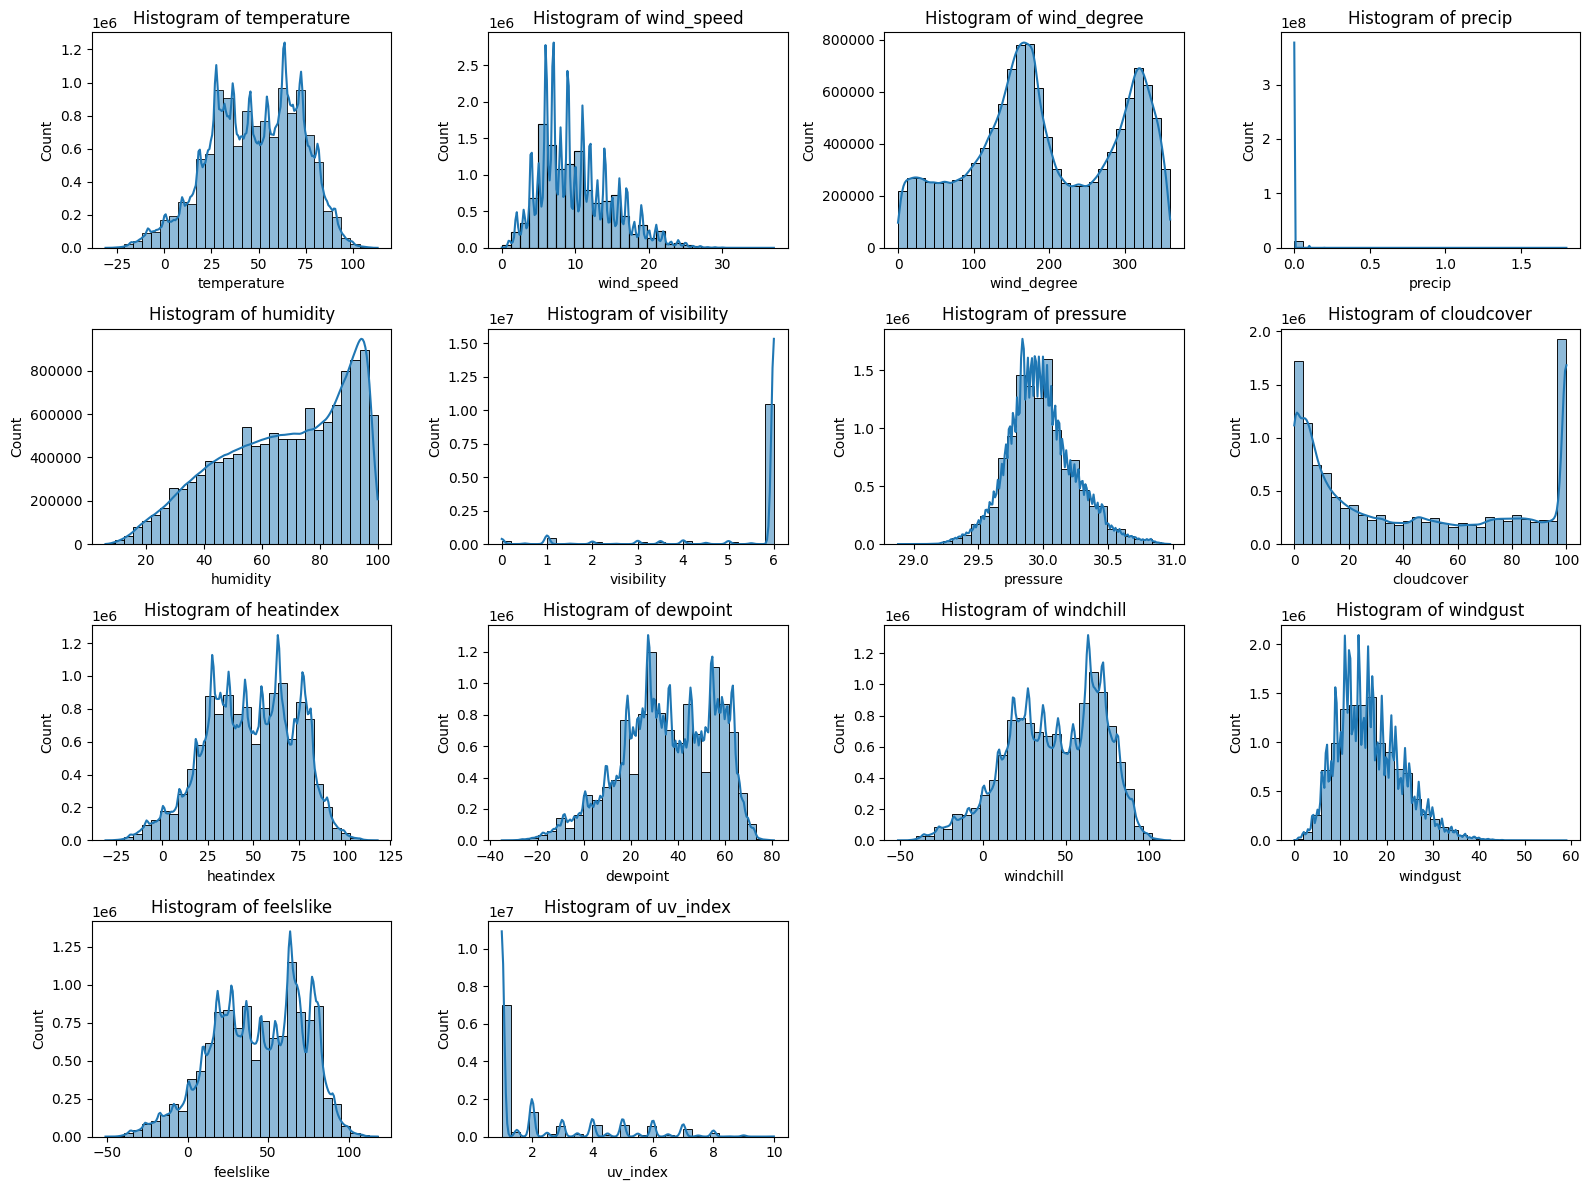

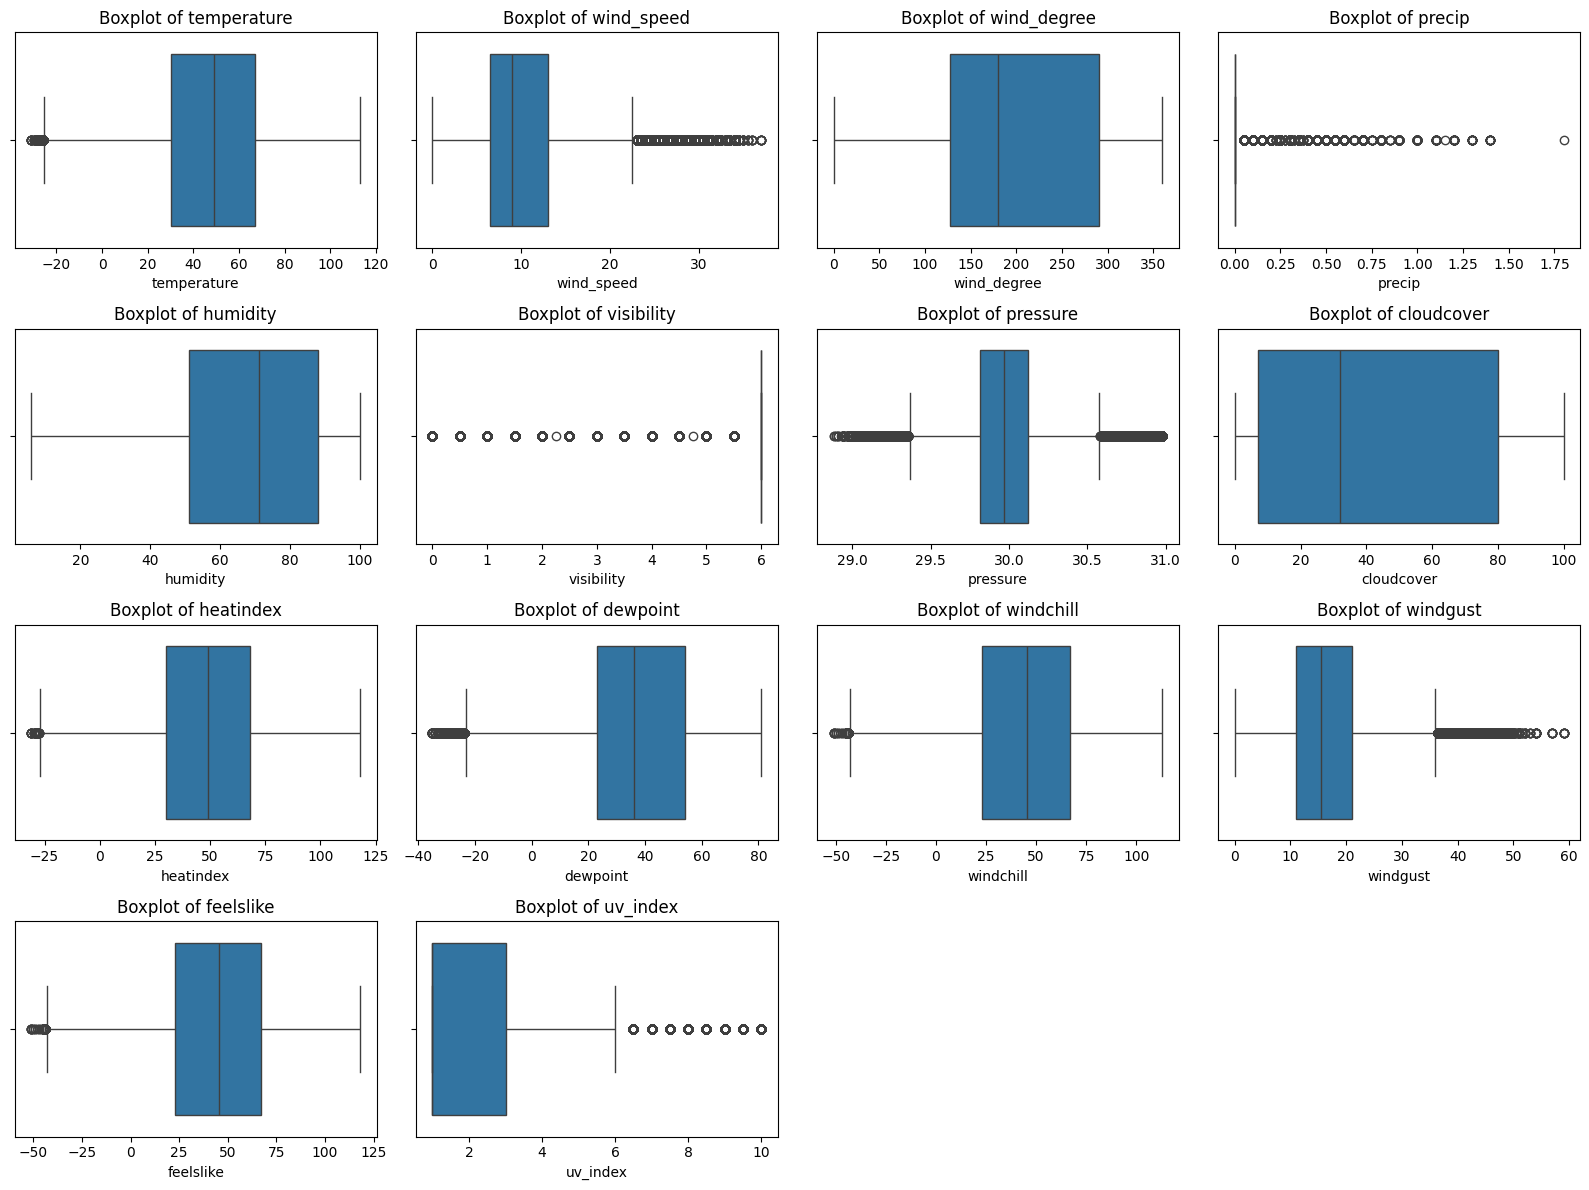

In [24]:
# Analyze the distribution of numeric variables with histograms
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    plt.subplot(4, 4, i+1)
    sns.histplot(df_parsed[col].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
plt.show()

# Analyze outliers using boxplots for numeric variables
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df_parsed[col].dropna())
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

Boxplots

1. Temperature, Heatindex, Feelslike, Windchill
    - These have a broad range (roughly -30°F to over 100°F) and a few outliers on the high end.
    - The distributions are fairly symmetric overall, indicating that extreme values do occur but are not overwhelmingly common.
    Wind Speed, Wind Degree

2. Wind Speed, Wind Degree
    - Wind Speed typically stays below 20–25 mph, with outliers extending up to ~35–40 mph.
    - Wind Degree spans the entire 0–360° range, which is expected since it measures wind direction. No single direction dominates, so the boxplot essentially covers the whole range with no “outliers” in the typical sense.

3. Precipitation

    - Most values are zero, with occasional spikes in the upper whiskers—suggesting a heavily skewed distribution. This matches the observation that the dataset is dominated by no-rain intervals.  

4. Humidity, Visibility, Pressure, Cloudcover

    - Humidity ranges widely (roughly 10% to 100%), though most values cluster around 50–80%.
    - Visibility has a small range (0 to ~6 mi in the boxplot), with outliers indicating lower visibility (likely fog or heavy precipitation events).
    - Pressure hovers around 29–31 inHg, typical of surface atmospheric pressure, with few outliers.
    - Cloudcover spans 0–100% with many mid-range values, indicating frequent partial cloudiness.

5. Dewpoint

    - Ranges from around -35°F to ~80°F, with a distribution that somewhat mirrors temperature but at lower absolute values.

6. Windgust

    - Generally in the same ballpark as wind speed but can spike higher (up to 50–60 mph). Outliers represent strong gust events.

7. UV Index

    - Concentrated in the lower range (1–3), with outliers up to 10, which likely occur in peak midday sunshine or summer months.


Histograms 
1. Temperature & Related Variables

    - Show near-bell-shaped distributions centered around moderate temperatures (40–60°F).
    - Heatindex, windchill, and feelslike shift similarly with temperature but extend into higher and lower extremes.

2. Wind Speed

    - Skewed right, with most values in the lower range (0–10 mph) and fewer high-wind events.

3. Wind Degree

    - Fairly uniform from 0–360°, reflecting that wind can blow from any direction.

4. Precipitation

    - Almost entirely 0 with a thin tail of non-zero values. This confirms that the dataset is dominated by dry periods, or that some precipitation events may be underrepresented or recorded as zeros.

5. Humidity

    - Peaks around 60–80%, typical of moderate-to-humid conditions. Tails extend down toward very dry (10%) and up to saturated (100%).

6. Visibility

    - Usually near 6 miles (the dataset’s maximum?), with some lower values indicating fog or precipitation events.

7.  Pressure

    - Tightly clustered around ~30 inHg, with a slight spread from ~28.9 to ~31.

8. Cloudcover

    - A broad distribution from 0–100%, with a modest peak in the middle, indicating partly cloudy skies are common.

9. Dewpoint

    - Shifts toward warmer values in summer months (up to ~80°F) and can drop below 0°F in colder seasons.

10. Windgust

     - Similar shape to wind speed but extends to higher extremes.

11. UV Index

    - Most values are 1–3, with a right tail up to 10. Strong UV episodes occur but are less frequent.

Overall Observations

1. Temperature‐Related Grouping: Temperature, feelslike, windchill, and heatindex are all highly correlated and exhibit similar shapes—implying potential redundancy in modeling.
2. Sparse Precipitation: The extremely high count of zeros suggests either truly dry conditions or measurement limitations. Supplementing this with alternative precipitation data might be necessary.
3. Wind Variability: Wind speed is generally moderate, but gusts can spike, which may be relevant for load forecasting if wind influences certain energy demand patterns.
4. Humidity & Cloudcover: These have broader distributions and could interact with temperature and precipitation in meaningful ways for forecasting.
5. UV Index Skew: Most data is low, but spikes to 10 highlight the stronger midday/summer sun.

Save formatted and cleaned all weather data to a JSON file. 

In [25]:
output_file = r'time_processed_weather.json'
df_parsed.to_json(output_file, orient='records', date_format='iso')
print(f"Updated dataframe saved to {output_file}")

Updated dataframe saved to time_processed_weather.json


In [1]:
!jupyter nbconvert --to pdf "all_hist_weather_time-interpolate.ipynb"

[NbConvertApp] Converting notebook all_hist_weather_time-interpolate.ipynb to pdf
[NbConvertApp] Support files will be in all_hist_weather_time-interpolate_files\
[NbConvertApp] Making directory .\all_hist_weather_time-interpolate_files
[NbConvertApp] Writing 85716 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2536552 bytes to all_hist_weather_time-interpolate.pdf


Next steps are to enhance the historical weather datasest with NOAA API

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# For XGBoost: define features, target, and apply scaling/splitting

# Example: Using numeric columns as features and temperature as target (adjust as needed)
features = df_parsed[num_cols].copy()
target = df_parsed['temperature']

# Be careful to maintain time-order for splitting (here shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("XGBoost data is prepared: features scaled and split.")

# For LSTM: create sequences from the features (assuming half-hour interval, adjust sequence_length as needed)

def create_sequences(data, sequence_length=48):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data.iloc[i:i+sequence_length].values)
    return np.array(sequences)

# Example: using the scaled training features for LSTM
sequence_length = 48  # adjust the look-back window as needed
X_train_seq = create_sequences(pd.DataFrame(X_train_scaled), sequence_length)
y_train_seq = target.iloc[sequence_length:].values  # be sure to align target with the sequences

print("LSTM data is prepared: features reshaped into sequences and ready for further modeling.")